In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         pass
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [21]:
os.chdir('../input/paddy-disease-classification')

In [25]:
train_path = '/train_images'
test_path = '/test_images'

In [27]:
from fastai.vision.all import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [29]:
resize_images('train_images', dest=train_path, max_size=256, recurse=True)

(192, 256)


<Axes: >

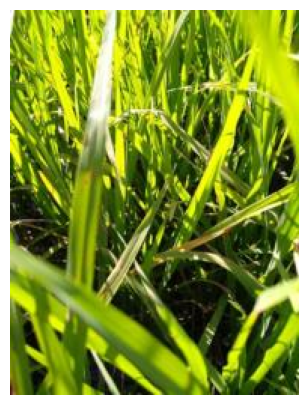

In [33]:
img = PILImage.create(train_path+'/blast/100004.jpg')
print(img.size)
img.show()

In [ ]:
# No need for that since there is already another one in the method

dls = ImageDataLoaders.from_folder(
    train_path,
    valid_pct=0.2, # Percent perserved for validation
    seed=42,
    item_tfms=Resize((320,240)))


# Zooming in (cropping) to reach the desired size
#     batch_tfms=aug_transforms(size=128, min_scale=0.75)


dls.show_batch(max_n=6)

In [34]:
def train(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_folder(train_path, seed=42, valid_pct=0.2, item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

In [35]:
# conext22 = vision_learner(dls, 'convnext_tiny_in22k', metrics=error_rate, path='.').to_fp16()
arch = 'convnext_tiny_in22k'
learn = train(arch, item=Resize(192, method='squish'), batch=aug_transforms(size=64, min_scale=0.75))

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,1.635708,1.151344,0.363287,01:40


epoch,train_loss,valid_loss,error_rate,time
0,0.884910,0.655691,0.209034,01:52
1,0.647734,0.557490,0.168188,01:52
2,0.435186,0.349308,0.112446,01:52
3,0.286661,0.246921,0.077367,01:51
4,0.210725,0.222460,0.066314,01:52


In [36]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)

In [37]:
error_rate(preds, targs)

TensorBase(0.0663)

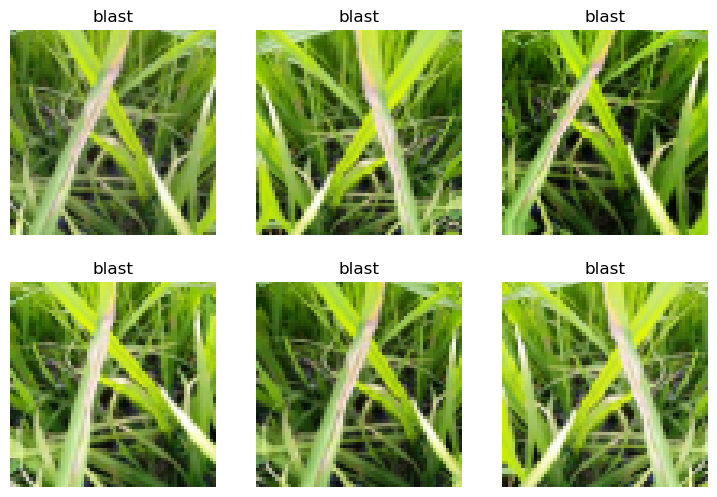

In [38]:
learn.dls.train.show_batch(max_n=6, unique=True)

In [39]:
tta_preds,_ = learn.tta(dl=valid)

In [40]:
error_rate(tta_preds, targs)

TensorBase(0.0553)

In [41]:
learn = train(arch, epochs=12,
              item=Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
              batch=aug_transforms(size=(256,192), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.168132,0.826923,0.256127,02:51


epoch,train_loss,valid_loss,error_rate,time
0,0.580609,0.396195,0.118212,03:13
1,0.483164,0.353560,0.116290,03:14
2,0.398713,0.392532,0.113888,03:14
3,0.341175,0.313082,0.092263,03:14
4,0.268275,0.243796,0.084094,03:14
5,0.238147,0.202098,0.058626,03:13
6,0.147212,0.157801,0.040846,03:10
7,0.115690,0.147828,0.037963,03:04
8,0.081789,0.120446,0.032196,03:03
9,0.060085,0.123847,0.031235,03:03


In [42]:
tta_preds,targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds, targs)

TensorBase(0.0284)

## Submission

In [45]:
from fastai.data.transforms import get_image_files

In [50]:
test_path = '/kaggle/input/paddy-disease-classification/test_images'

In [76]:
test_files = get_image_files(test_path).sorted()
test_files = learn.dls.test_dl(test_files)

# Doing the test time augmentations on the test dataset.
preds,_ = learn.get_preds(dl=test_files)

# So these are our predictions for the kaggle testset.

In [77]:
# Preds is a table which has rows equal to number of test images and columns equal to each class
# We will get the column with the strongest value and take it as predicted class for the row
idxs = preds.argmax(dim=1)

In [78]:
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name="idxs")

In [79]:
ss = pd.read_csv('/kaggle/input/paddy-disease-classification/sample_submission.csv')
ss['label'] = results

In [80]:
ss.to_csv('/kaggle/working/submission.csv', index=False)
!head /kaggle/working/submission.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In [63]:
!kaggle competitions submit -c paddy-disease-classification -f /kaggle/woking/submission.csv -m "Message"

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.10/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 181, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
